# **Importing Libraries & Data**

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
# importing the csv file
df1 = pd.read_csv('online_retail_one_year.csv')
df2 = pd.read_excel('online_retail_multi_year.xlsx')

df1.columns = df1.columns.str.strip().str.replace(" ", "")
df2.columns = df2.columns.str.strip().str.replace(" ", "")

data = pd.concat([df1, df2], axis=0, ignore_index=True)
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# **Data Quality Checks**

In [75]:
# Check size of dataset
data.shape

(1592832, 8)

In [76]:
# Check for missing values
data.isnull().sum()

,0
Invoice,0
StockCode,0
Description,7310
Quantity,0
InvoiceDate,0
Price,0
CustomerID,350934
Country,0


In [77]:
# Understanding the data types of all columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1592832 entries, 0 to 1592831
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1592832 non-null  object 
 1   StockCode    1592832 non-null  object 
 2   Description  1585522 non-null  object 
 3   Quantity     1592832 non-null  int64  
 4   InvoiceDate  1592832 non-null  object 
 5   Price        1592832 non-null  float64
 6   CustomerID   1241898 non-null  float64
 7   Country      1592832 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 97.2+ MB


In [78]:
# Check for duplicate records
data.duplicated().sum()

np.int64(41200)

# **Data Cleaning**

In [79]:
# Delete rows with missing Customer ID
data.dropna(subset=['CustomerID'], inplace=True)

In [80]:
# Convert the datatype of InvoiceDate to DateTime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Convert the dataype of Customer ID to int
data['CustomerID'] = data['CustomerID'].astype(int)

In [81]:
# Drop all duplicate records
data.drop_duplicates(inplace=True)

In [82]:
# Remove cancelled and returned orders
data = data[~data['Invoice'].astype(str).str.startswith('C')]


# Remove Items with negative prices and quantity
data = data[data['Quantity'] > 0]
data = data[data['Price'] > 0]

In [83]:
# Create new column, Revenue = Quantity * Price
data['Revenue'] = data['Quantity'] * data['Price']

# **Feature Engineering**

In [84]:
# Construct new features Order Date & Order Month
data['OrderDate'] = data['InvoiceDate'].dt.date
data['OrderMonth'] = data['InvoiceDate'].dt.month

In [85]:
# first purchase per customer
first_purchase = data.groupby('CustomerID')['InvoiceDate'].min().reset_index()
first_purchase.columns = ['CustomerID', 'FirstPurchaseDate']

data = data.merge(first_purchase, on='CustomerID', how='left')

In [86]:
# Cohort month
data['CohortMonth'] = data['FirstPurchaseDate'].dt.to_period('M')

In [87]:
# New v/s. Repeat Customer Flag
data['RepeatCustomer'] = data.groupby('CustomerID')['Invoice'].transform('nunique') > 1

In [88]:
# Basket Level Revenue
data['BasketLevelRevenue'] = data.groupby(['Invoice', 'CustomerID'])['Revenue'].transform('sum')

# **Exploratory Data Analysis (EDA)**

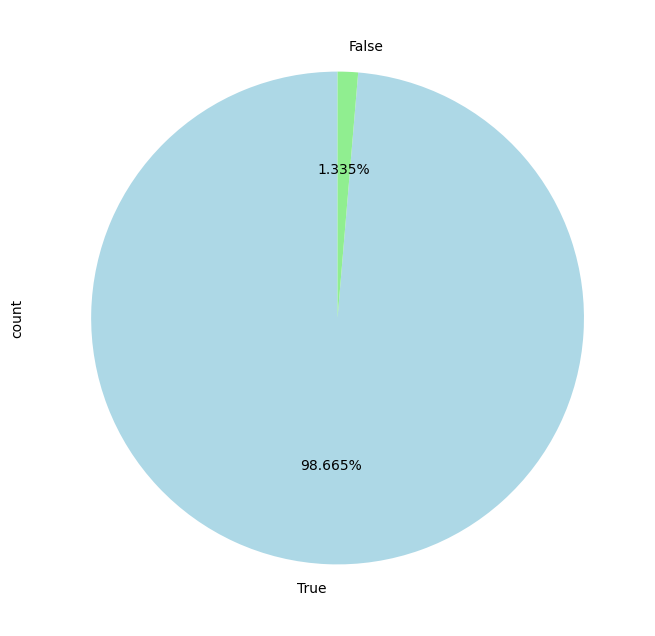

In [89]:
# Pie Chart of Repeat v/s. One Time Customer
plt.figure(figsize=(8, 8))
data['RepeatCustomer'].value_counts().plot(kind='pie', autopct='%1.3f%%', startangle=90, colors=['lightblue', 'lightgreen'])
plt.show()

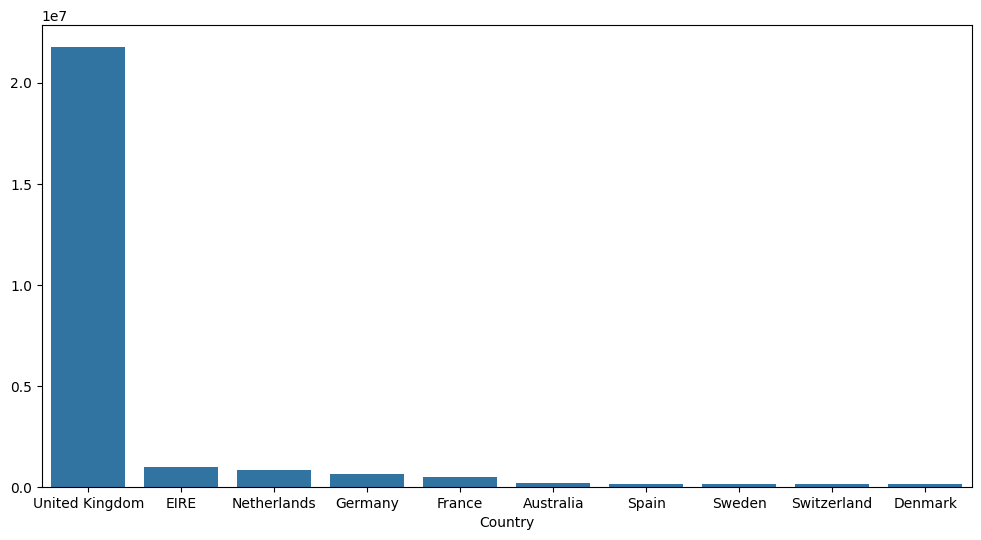

In [90]:
# Top country by revenue v/s. total transactions
top_countries = data.groupby('Country')['Revenue'].sum().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.show()


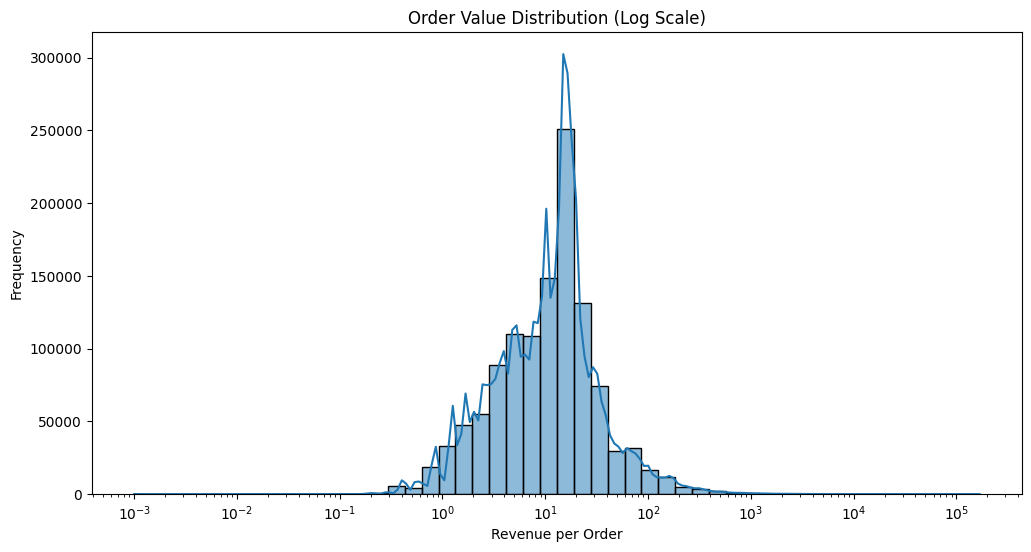

In [91]:
# Histogram of Order Value Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data['Revenue'], bins=50, kde=True, log_scale=True)
plt.title("Order Value Distribution (Log Scale)")
plt.xlabel("Revenue per Order")
plt.ylabel("Frequency")
plt.show()

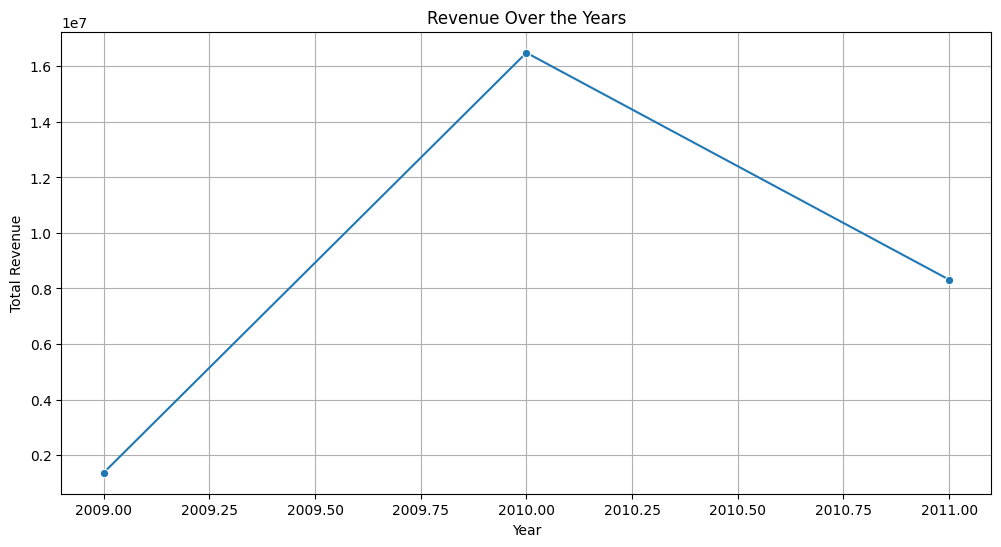

In [92]:
# Revenue over the years
data['Year'] = data['InvoiceDate'].dt.year

# Aggregate revenue per year
yearly_revenue = data.groupby('Year')['Revenue'].sum().reset_index()

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(x='Year', y='Revenue', data=yearly_revenue, marker='o')
plt.title("Revenue Over the Years")
plt.xlabel("Year")
plt.ylabel("Total Revenue")
plt.grid(True)
plt.show()

/tmp/ipython-input-451937911.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Year', y='Revenue', data=yearly_revenue, palette='Blues_d')


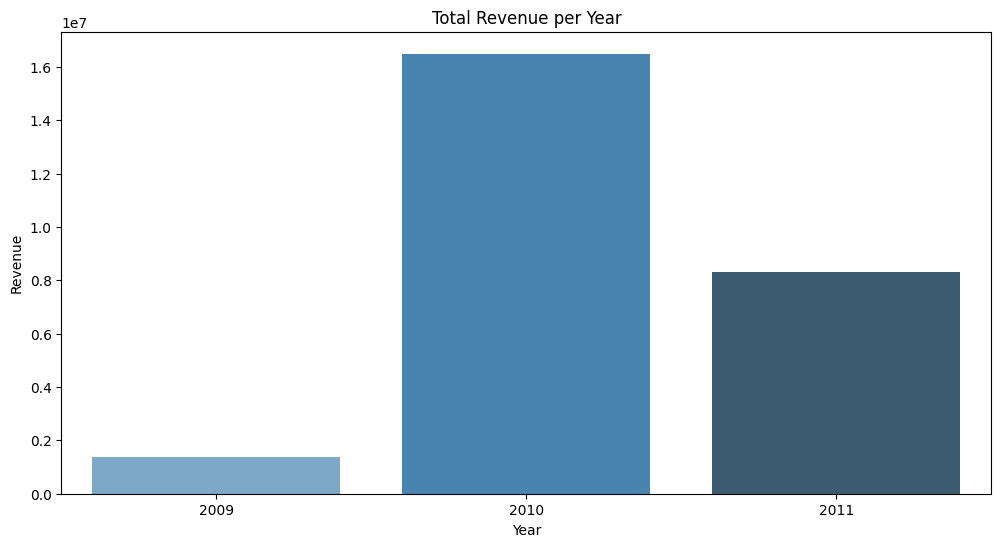

In [93]:
# Aggregate revenue per year
yearly_revenue = data.groupby('Year')['Revenue'].sum().reset_index()

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x='Year', y='Revenue', data=yearly_revenue, palette='Blues_d')
plt.title("Total Revenue per Year")
plt.ylabel("Revenue")
plt.xlabel("Year")
plt.show()

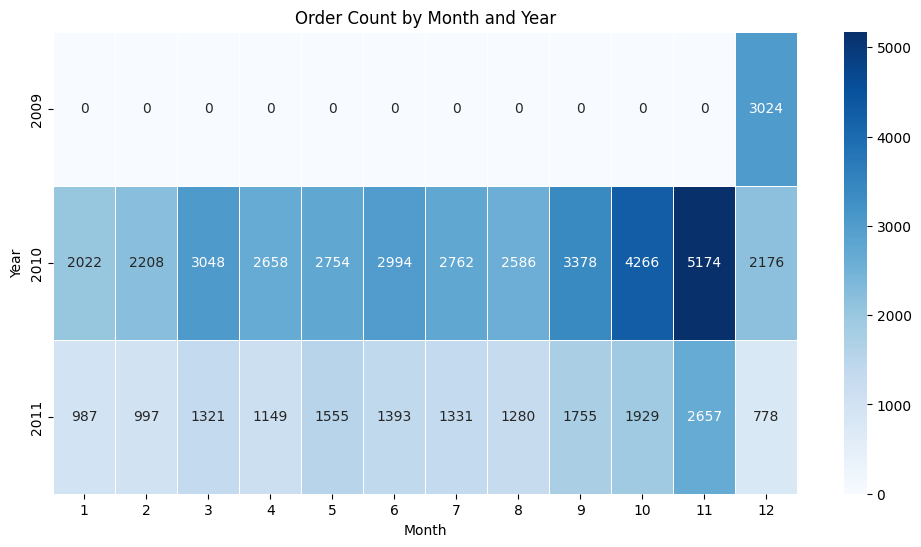

In [94]:
# HeatMap of Month V/S. Year with order count
monthly_orders = data.groupby(['Year', 'OrderMonth'])['Invoice'].nunique().reset_index()

# Pivot
pivot_orders = monthly_orders.pivot(index='Year', columns='OrderMonth', values='Invoice')
pivot_orders = pivot_orders.reindex(columns=range(1,13))  # Ensure Jan-Dec order

# Convert all values to integers (NaN will stay NaN)
pivot_orders = pivot_orders.fillna(0).astype(int)

plt.figure(figsize=(12,6))
sns.heatmap(pivot_orders, cmap='Blues', annot=True, fmt='d', linewidths=0.5)
plt.title("Order Count by Month and Year")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

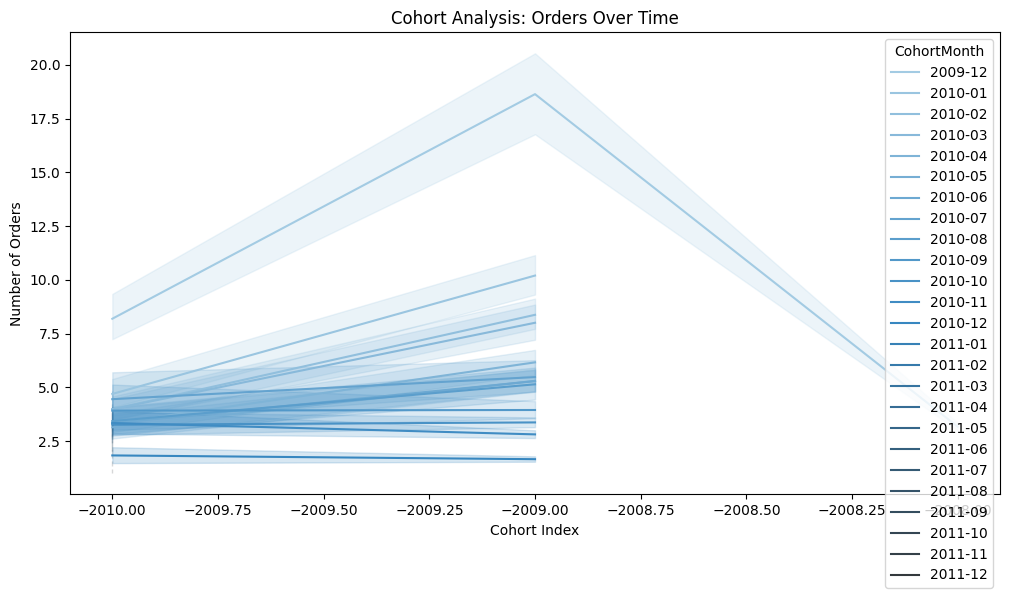

In [95]:
# Cohort Analysis Across Years
cohort_data = data.groupby(['CohortMonth', 'Year', 'CustomerID']).agg({'Invoice': 'nunique'}).reset_index()
cohort_data['CohortIndex'] = (cohort_data.groupby('CustomerID')['CohortMonth'].transform('nunique') - cohort_data['Year'])

plt.figure(figsize=(12,6))
sns.lineplot(x='CohortIndex', y='Invoice', hue='CohortMonth', data=cohort_data, palette='Blues_d')
plt.title("Cohort Analysis: Orders Over Time")
plt.xlabel("Cohort Index")
plt.ylabel("Number of Orders")
plt.show()


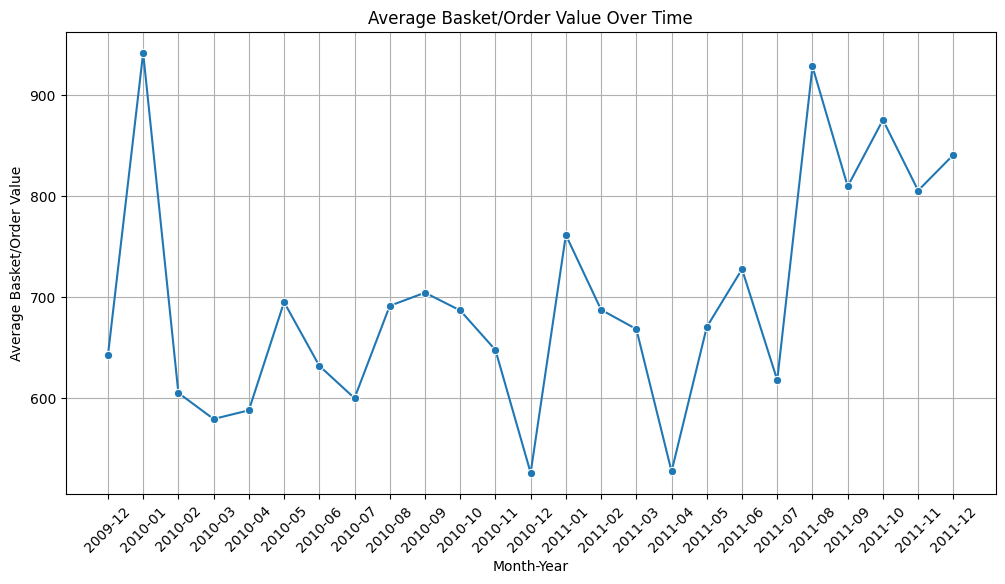

In [96]:
# Average Basket/Order Value across month-year
data['OrderDate'] = pd.to_datetime(data['OrderDate'])

# Create Month-Year column
data['MonthYear'] = data['OrderDate'].dt.to_period('M')

# Compute average basket value per month
avg_basket_value = data.groupby('MonthYear')['BasketLevelRevenue'].mean().reset_index()

# Convert MonthYear to string for plotting
avg_basket_value['MonthYearStr'] = avg_basket_value['MonthYear'].astype(str)

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(x='MonthYearStr', y='BasketLevelRevenue', data=avg_basket_value, marker='o')
plt.title("Average Basket/Order Value Over Time")
plt.xlabel("Month-Year")
plt.ylabel("Average Basket/Order Value")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### **Overall Business Takeaways**

* **Loyalty drives revenue:** Repeat customers dominate purchases, so retention strategies are key.

* **Seasonality matters:** Sales and basket size fluctuate over the year; align marketing and inventory planning with peak periods.

* **Market concentration:** UK contributes the majority of revenue; international expansion could unlock growth.

* **Revenue optimization opportunities:** Most orders are small-to-medium; consider bundles, promotions, and upselling to increase AOV.

* **Monitor trends:** Significant revenue spikes in 2010 and dips in 2011 indicate the business is sensitive to external factors and seasonal cycles.

# **Funnel Analysis**

#### **Funnel: Customer Value & Retention Funnel**
TotalOrders → AvgItemsPerOrder → TotalRevenue → RepeatCustomerRate

In [97]:
funnel_yearly = data.groupby('Year').agg(
    TotalOrders=('Invoice', 'nunique'),
    AvgItemsPerOrder=('Quantity', 'mean'),
    TotalRevenue=('Revenue', 'sum'),
    RepeatCustomerRate=('CustomerID', lambda x: x.duplicated().mean()*100)
).reset_index()

In [98]:
funnel_yearly['AvgItemsPerOrder'] = funnel_yearly['AvgItemsPerOrder'].round(2)
funnel_yearly['TotalRevenue'] = funnel_yearly['TotalRevenue'].round(2)
funnel_yearly['RepeatCustomerRate'] = funnel_yearly['RepeatCustomerRate'].round(2)

display(funnel_yearly)

,Year,TotalOrders,AvgItemsPerOrder,TotalRevenue,RepeatCustomerRate
0,2009,3024,13.17,1367008.02,98.42
1,2010,36026,13.81,16489225.83,99.44
2,2011,17132,13.19,8316804.16,98.85


In [99]:
funnel_normalized = funnel_yearly.copy()
stages = ['TotalOrders', 'AvgItemsPerOrder', 'TotalRevenue', 'RepeatCustomerRate']

for stage in stages:
    funnel_yearly[stage + "_%"] = (funnel_yearly[stage] / funnel_yearly[stage].max() * 100).round(2)

display(funnel_yearly)

,Year,TotalOrders,AvgItemsPerOrder,TotalRevenue,RepeatCustomerRate,TotalOrders_%,AvgItemsPerOrder_%,TotalRevenue_%,RepeatCustomerRate_%
0,2009,3024,13.17,1367008.02,98.42,8.39,95.37,8.29,98.97
1,2010,36026,13.81,16489225.83,99.44,100.00,100.00,100.00,100.00
2,2011,17132,13.19,8316804.16,98.85,47.55,95.51,50.44,99.41


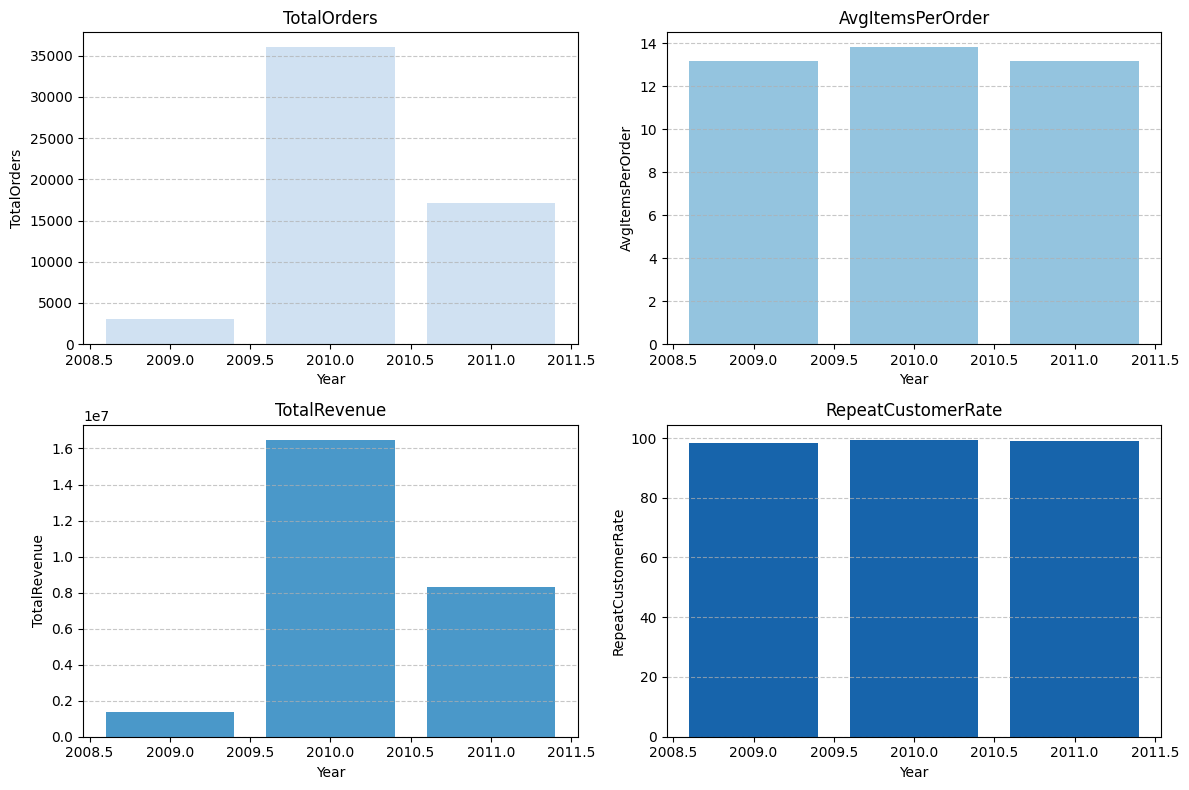

In [100]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
axes = axes.flatten()

for idx, stage in enumerate(stages):
    axes[idx].bar(funnel_yearly['Year'], funnel_yearly[stage], color=colors[idx])
    axes[idx].set_title(stage)
    axes[idx].set_xlabel("Year")
    axes[idx].set_ylabel(stage)
    axes[idx].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### **Funnel: Customer Value & Retention Funnel**
(Total Orders → Avg Items per Order → Total Revenue → Repeat Customer Rate)

**Key Results**

2009: Total Orders = 3,024, Avg Items per Order = 13.17, Total Revenue = 1,367,008.02, Repeat Customer Rate = 98.42%  
2010: Total Orders = 36,026, Avg Items per Order = 13.81, Total Revenue = 16,489,225.83, Repeat Customer Rate = 99.44%  
2011: Total Orders = 17,132, Avg Items per Order = 13.19, Total Revenue = 8,316,804.16, Repeat Customer Rate = 98.85%

---

**Conclusion**

The multi-year analysis shows strong customer loyalty with repeat customer rates consistently above 98%. Total orders and revenue peaked in 2010, highlighting a year of significant growth, while average items per order remained stable across the years. The slight dip in 2011’s total orders and revenue suggests a minor slowdown, but repeat customer behavior remained resilient.

---

**Business Implication**

Sustaining high repeat purchase rates ensures stable revenue streams. To maximize customer lifetime value, the business can focus on strategies that encourage higher order frequency or slightly larger order sizes, especially during slower years, without incurring additional customer acquisition costs.
